Setup PyTorch to use best hardware option

In [1]:
import torch

torch.backends.cuda.matmul.allow_tf32 = True

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [2]:
ARTIFACTS_BASE = '../../../artifacts'

In [3]:
from os import path
from datasets import load_from_disk

dataset_path = path.join(ARTIFACTS_BASE, 'datasets', 'jayavibhav/prompt-injection')

train_dataset_split = load_from_disk(path.join(dataset_path, 'train')).train_test_split(test_size=0.2)
train_dataset = train_dataset_split['train'].rename_column('text', 'prompt')
eval_dataset = train_dataset_split['test'].rename_column('text', 'prompt')

test_dataset = load_from_disk(path.join(dataset_path, 'test'))
test_dataset = test_dataset.rename_column('text', 'prompt')


In [4]:
train_dataset

Dataset({
    features: ['prompt', 'label'],
    num_rows: 209390
})

In [5]:
eval_dataset

Dataset({
    features: ['prompt', 'label'],
    num_rows: 52348
})

In [6]:
test_dataset

Dataset({
    features: ['prompt', 'label'],
    num_rows: 65416
})

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "distilbert/distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=False, use_fast=True, max_length=512)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
model.eval()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [8]:
# A utility function to receive a batch of data and tokenize the prompts
def tokenize_batch(batch):
    return tokenizer(batch['prompt'], padding="max_length", truncation=True, max_length=512)

In [9]:
# Tokenize prompts in both training and testing datasets
prompts_train_tokenized = train_dataset.map(tokenize_batch, batched=True) 
prompts_eval_tokenized = eval_dataset.map(tokenize_batch, batched=True) 

Map:   0%|          | 0/209390 [00:00<?, ? examples/s]

Map:   0%|          | 0/52348 [00:00<?, ? examples/s]

In [10]:
# Import TrainingArguments to handle the various training configurations
from transformers import TrainingArguments

# Define training arguments for fine-tuning
# GPU NVIDIA RTX A4500
training_args = TrainingArguments(
    output_dir="./results",
    logging_dir="./results/logs",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    tf32=True,
    num_train_epochs=3,
    torch_compile=True,
    load_best_model_at_end=True,
    dataloader_num_workers=4
)

In [11]:
import pandas as pd

# Initialize a DataFrame to track the model's performance
results_df = pd.DataFrame(columns=["epoch","accuracy","precision","recall","f1"])

In [12]:
# Import accuracy metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# A utility function for model evaluation during fine-tuning
def evaluate_model(trainer, epoch):
    
    # Extract predictions and labels
    predictions = trainer.predictions.argmax(axis=1)

    labels = trainer.label_ids
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)
    
    # Calculate precision, recall, and f1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    
    # Append current metrics to results
    global results_df
    results_df.loc[len(results_df)] = [epoch, accuracy, precision, recall, f1]
        
    # Return
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [13]:
# Import the Trainer class
from transformers import Trainer

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=prompts_train_tokenized,
    eval_dataset=prompts_eval_tokenized,
    tokenizer=tokenizer,
    compute_metrics=lambda p: evaluate_model(p, trainer.state.epoch),
)

In [14]:
# Fine-tune the model
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.025100,0.028765,0.994250,0.996248,0.992022,0.994130
2,0.014600,0.026681,0.994861,0.993901,0.995641,0.994770
3,0.005300,0.024809,0.995855,0.996608,0.994941,0.995774


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

TrainOutput(global_step=19632, training_loss=0.022582503319539572, metrics={'train_runtime': 5010.9172, 'train_samples_per_second': 125.36, 'train_steps_per_second': 3.918, 'total_flos': 8.321204581373952e+16, 'train_loss': 0.022582503319539572, 'epoch': 3.0})

In [15]:
results_df

,epoch,accuracy,precision,recall,f1
0,1.0,0.994250,0.996248,0.992022,0.994130
1,2.0,0.994861,0.993901,0.995641,0.994770
2,3.0,0.995855,0.996608,0.994941,0.995774


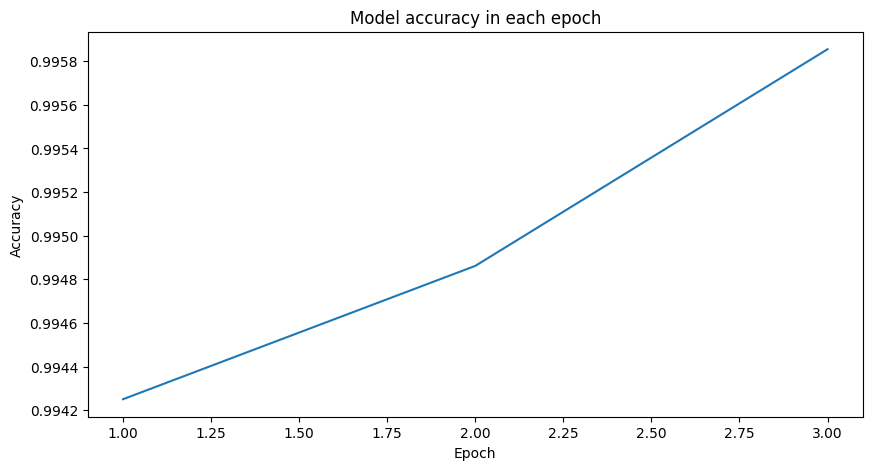

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the accuracy in each epoch

# Create a figure
plt.figure(figsize=(10,5))

# Plot samples
sns.lineplot(data=results_df, x="epoch", y="accuracy")

# Set figure title and axes labels
plt.title("Model accuracy in each epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# Show the plot
plt.show()

In [17]:
final_results = trainer.evaluate()
print(final_results)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'eval_loss': 0.02480878122150898, 'eval_accuracy': 0.995854664934668, 'eval_precision': 0.9966084515827226, 'eval_recall': 0.9949406499318934, 'eval_f1': 0.9957738524159152, 'eval_runtime': 152.2834, 'eval_samples_per_second': 343.754, 'eval_steps_per_second': 10.743, 'epoch': 3.0}


In [19]:
output_dir = "./final_results"
model.save_pretrained(output_dir + "/distilroberta-base-model")
tokenizer.save_pretrained(output_dir + "/distilroberta-base-tokenizer")

('./final_results/distilroberta-base-tokenizer/tokenizer_config.json',
 './final_results/distilroberta-base-tokenizer/special_tokens_map.json',
 './final_results/distilroberta-base-tokenizer/vocab.json',
 './final_results/distilroberta-base-tokenizer/merges.txt',
 './final_results/distilroberta-base-tokenizer/added_tokens.json',
 './final_results/distilroberta-base-tokenizer/tokenizer.json')

In [20]:
prompts_test_tokenized = test_dataset.map(tokenize_batch, batched=True)

Map:   0%|          | 0/65416 [00:00<?, ? examples/s]

In [21]:
from tqdm import tqdm

batch_size = 16
predictions = []
total_batches = len(prompts_test_tokenized) // batch_size + (1 if len(prompts_test_tokenized) % batch_size != 0 else 0)

with torch.no_grad():
    progress_bar = tqdm(total=total_batches, desc="Running inference", unit="batch")
    for batch in prompts_test_tokenized.select_columns(["input_ids", "attention_mask"]).with_format("torch").iter(batch_size=batch_size):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        predictions.extend(outputs.logits.argmax(dim=-1).tolist())
        progress_bar.update(1)
    
    progress_bar.close()

Running inference: 100%|██████████| 4089/4089 [03:15<00:00, 20.94batch/s]


In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

true_labels = prompts_test_tokenized["label"]
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

In [23]:
import pandas as pd

metrics_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})

# Format all columns to display 4 decimal places
for column in metrics_df.columns:
    metrics_df[column] = metrics_df[column].apply(lambda x: f"{x:.4f}")

metrics_df

,Accuracy,Precision,Recall,F1 Score
0,0.9962,0.9965,0.9958,0.9961
